In [411]:
from sklearn.metrics import mean_absolute_error, r2_score, mean_squared_error, mean_absolute_percentage_error, f1_score
from sklearn.preprocessing import MinMaxScaler, StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LinearRegression
from time import gmtime, strftime
import matplotlib.pyplot as plt
from scipy import stats
import seaborn as sns
import pandas as pd
import numpy as np
features = [
  'delivery_type', 'total_size', 'distance', 
  'delivery_dt', 'lat', 'long', 'task_around',

  'pickup_effective_dt', 'city', 'total_task'
]
stad_cols = [
  'total_size', 'distance',
  'task_around',
]
stad_cols_2 = [
  'lat', 'long'
]
stad_dates = [
  'delivery_dt', 'pickup_effective_dt'
]
#'pickup_effective_dt',
target = 'delivery_effective'
RANDOM = 1999

RESULTS = './results.csv'

In [412]:
class display(object):
  """Display HTML representation of multiple objects"""
  template = """<div style="float: left; padding: 10px;">
  <p style='font-family:"Courier New", Courier, monospace'>{0}</p>{1}
  </div>"""
  def __init__(self, *args):
    self.args = args

  def _repr_html_(self):
    return '\n'.join(self.template.format(a, eval(a)._repr_html_()) for a in self.args)

  def __repr__(self):
    return '\n\n'.join(a + '\n' + repr(eval(a)) for a in self.args)

def save_params(scalers, metrics):
  metrics_values = []
  for value in metrics.values():
    metrics_values.append(str(value))
  metada = []
  for key, value in scalers.items():
    metada.append({ key: value })
  with open(RESULTS, 'a') as f:
    f.write(f'{",".join(metrics_values)},{metada}\n')

In [413]:
df = pd.read_pickle("../data/shippify_icd_task_new.pkl", compression='gzip')
#df = df[ (df['delivery_dt'].dt.month >= 6) & (df['delivery_dt'].dt.month <= 7) ]
#df = df[ df['delivery_dt'].dt.month == 6 ]
df.delivery_type = df.delivery_type.astype('category').cat.codes
df.total_size = df.total_size.astype('category').cat.codes

df.delivery_dt = df.delivery_dt.view('i8') / 1e9
df.pickup_effective_dt = df.pickup_effective_dt.view('i8') / 1e9
df.delivery_effective = df.delivery_effective.view('i8') / 1e9

""" z_scores = stats.zscore(df['task_around'])
abs_z_scores = np.abs(z_scores)
filtered_entries = abs_z_scores < 3
df = df[ filtered_entries ] """
pass

In [414]:
df[ df['delivery_dt'] > df['delivery_effective']]

,id,route_id,creation_date,delivery_type,city,cost,total_size,distance,company_id,company_type,...,delivery_dt,delivery_effective,lat,long,delivery_location,items,total_task,is_late,task_around,class_neighboring
0,t-expspa-41,None,2020-08-07 18:51:07+00:00,1,3,2363.199951,1,4.700000,5632,1,...,1.596838e+09,1.596834e+09,-33.474602,-70.566498,"{""lat"":-33.4746198,""lng"":-70.5664998,""instruct...","[{""name"":""Pro Plan - PACK Puppy Small 75Kg + 2...",226828,False,70,"(-0.001, 100.0]"
1,t-expspa-25,r-shiinc-298920,2020-07-13 15:50:46+00:00,0,3,3120.000000,1,14.500000,5632,1,...,1.594674e+09,1.594670e+09,-33.554600,-70.605698,"{""lat"":-33.554590999,""lng"":-70.6056534,""instru...","[{""name"":""Pro plan - PACK Sterilized Cat 75Kg ...",226828,False,41,"(-0.001, 100.0]"
4,t-expspa-29,r-shiinc-304797,2020-07-20 15:58:20+00:00,0,3,4080.000000,0,19.700001,5632,1,...,1.595282e+09,1.595281e+09,-33.450298,-70.762901,"{""lat"":-33.450334499,""lng"":-70.7629295,""instru...","[{""name"":""Royal Canin - Maxi Adulto 15Kg."",""qt...",226828,False,14,"(-0.001, 100.0]"
5,t-expspa-23,r-shiinc-297314,2020-07-10 14:48:48+00:00,0,3,3120.000000,1,19.900000,5632,1,...,1.594414e+09,1.594414e+09,-33.450401,-70.762802,"{""lat"":-33.4504296,""lng"":-70.7627742,""instruct...","[{""name"":""Pack 12 sachet 85g + Cat Chow 8Kg"",""...",226828,False,16,"(-0.001, 100.0]"
8,t-castec-519,r-shiinc-336904,2020-08-21 15:59:32+00:00,0,3,2552.000000,4,20.100000,5889,1,...,1.598051e+09,1.598048e+09,-33.501900,-70.566002,"{""lat"":-33.501941099,""lng"":-70.566012399,""addr...","[{""name"":""Xiaomi 70mai 1s"",""qty"":1,""size"":1,""p...",226828,False,63,"(-0.001, 100.0]"
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
251815,t-festda-127,r-shiinc-318001,2020-08-04 14:49:12+00:00,0,3,2240.000000,4,1.900000,5885,1,...,1.596568e+09,1.596567e+09,-33.417099,-70.593300,"{""lat"":-33.417057999,""lng"":-70.5933177,""addres...","[{""name"":""23137"",""qty"":1,""size"":1,""price"":0,""w...",226828,False,396,"(300.0, 400.0]"
251817,t-festda-99,r-shiinc-311697,2020-07-28 05:12:14+00:00,0,3,2240.000000,4,4.700000,5885,1,...,1.595966e+09,1.595964e+09,-33.440201,-70.609802,"{""lat"":-33.440227999,""lng"":-70.609772,""instruc...","[{""name"":""23059"",""qty"":1,""size"":1,""price"":0,""w...",226828,False,306,"(300.0, 400.0]"
251818,t-festda-117,None,2020-07-29 16:27:07+00:00,0,3,7120.000000,4,16.100000,5885,1,...,1.596146e+09,1.596136e+09,-33.523300,-70.653702,"{""lat"":-33.523260199,""lng"":-70.6537183,""instru...","[{""name"":""sawa (29/07/2020)"",""qty"":1,""size"":1,...",226828,False,43,"(-0.001, 100.0]"
251819,t-festda-97,r-shiinc-311697,2020-07-28 04:53:46+00:00,0,3,2240.000000,4,9.700000,5885,1,...,1.595969e+09,1.595965e+09,-33.487202,-70.604698,"{""lat"":-33.4871977,""lng"":-70.604682099,""instru...","[{""name"":""23069"",""qty"":1,""size"":1,""price"":0,""w...",226828,False,63,"(-0.001, 100.0]"


In [415]:
scaler = MinMaxScaler(feature_range=(0, 10))
df[stad_cols] = scaler.fit_transform(df[stad_cols])

scaler_2 = MinMaxScaler(feature_range=(0, 10))
df[stad_cols_2] = scaler_2.fit_transform(df[stad_cols_2])

scaler_3 = MinMaxScaler(feature_range=(0, 100))
df[stad_dates] = scaler_3.fit_transform(df[stad_dates])

""" scaler_target = MinMaxScaler(feature_range=(0, 1000))
df[target] = scaler_target.fit_transform(df[[target]]) """

' scaler_target = MinMaxScaler(feature_range=(0, 1000))\ndf[target] = scaler_target.fit_transform(df[[target]]) '

In [416]:
X_train, X_test, y_train, y_test = train_test_split(df[features], df[target], test_size=0.25, random_state=RANDOM)

model = LinearRegression()
reg = model.fit(X_train, y_train)
"""
MAE  14291.68545723561
MAPE  8.975251299191215e-06
RMSE  43606.385764242266
R2  0.9963369581756835
"""
y_pred = model.predict(X_test)

pred_bool = np.where(y_pred > X_test['delivery_dt'], True, False)
test_bool = np.where(y_test > X_test['delivery_dt'], True, False)

mae = mean_absolute_error(y_test, y_pred)
mape = mean_absolute_percentage_error(y_test, y_pred)
rmse = mean_squared_error(y_test, y_pred, squared=False)
r2 = r2_score(y_test, y_pred)

In [417]:
THRESHOLD = 2
X_test['pred'] = y_pred * 1e9 #scaler_target.inverse_transform(np.array(y_pred).reshape(-1,1))
X_test['delivery_effective'] = y_test * 1e9#scaler_target.inverse_transform(np.array(y_test).reshape(-1,1))
X_test[stad_dates] = scaler_3.inverse_transform(X_test[stad_dates]) * 1e9
X_test.delivery_dt = X_test.delivery_dt.astype('datetime64[ns]')
X_test.delivery_effective = X_test.delivery_effective.astype('datetime64[ns]')
X_test.pred = X_test.pred.astype('datetime64[ns]')
X_test['delta'] = (X_test['delivery_effective'] - X_test['pred']).dt.total_seconds().apply(abs) / 3600

delta_pred_bool = np.where(((X_test['pred'] - X_test['delivery_dt']).dt.total_seconds()/3600) > THRESHOLD, True, False)
delta_test_bool = np.where(((X_test['delivery_effective'] - X_test['delivery_dt']).dt.total_seconds()/3600) > THRESHOLD, True, False)

f1_delta = f1_score(delta_pred_bool, delta_test_bool)

save_params({
  'stad_cols': scaler.get_params(deep=True),
  'stad_cols_2': scaler_2.get_params(deep=True),
  'stad_dates': scaler_3.get_params(deep=True),
},{
  'MAE':  mae,
  'MAPE':  mape,
  'RMSE':  rmse,
  'R2':  r2,
  'f1': f1_delta
})
print('{0:10s}: {1}\n{2:10s}: {3}\n{4:10s}: {5}\n{6:10s}: {7}\n{8:10s}: {9}'.format('MAE', mae, 'MAPE', mape, 'RMSE', rmse, 'r2', r2, 'f1 (delta)', f1_delta))

MAE       : 14522.615811060077
MAPE      : 9.105081277077554e-06
RMSE      : 62487.42041607615
r2        : 0.9992624931125533
f1 (delta): 0.7803464644596511


In [420]:
#print(X_test[ X_test['delta'] > 20 ].describe())
X_test[ X_test['delta'] > 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,pred,delivery_effective,delta
103689,1,10.0,0.078276,2020-07-22 20:20:45,8.627886,0.266205,2.776058,1.595429e+18,3,226828,2020-07-22 17:32:53.780469760,2020-07-28 19:36:52,146.066172
13094,1,2.5,0.093397,2020-06-12 14:30:00,8.856669,0.308385,1.517028,1.591971e+18,3,226828,2020-06-12 20:06:26.657784064,2020-06-14 14:29:18,42.380928
247720,1,2.5,0.064340,2020-08-22 13:00:34,8.514768,0.254371,1.279670,1.598116e+18,3,226828,2020-08-22 23:13:09.498931968,2020-08-24 03:28:53,28.262084
219798,1,2.5,0.115338,2020-07-30 16:00:00,7.485217,0.246485,0.712074,1.596139e+18,3,226828,2020-07-31 04:46:38.321840640,2020-08-04 23:21:14,114.576577
169664,1,2.5,0.071753,2020-07-20 16:00:00,8.613102,0.257755,4.716202,1.595260e+18,3,226828,2020-07-20 21:37:10.618684672,2020-07-22 20:04:05,46.448439
...,...,...,...,...,...,...,...,...,...,...,...,...,...
220265,1,2.5,0.056335,2020-07-20 16:00:00,8.642669,0.216379,0.763674,1.595260e+18,3,226828,2020-07-20 21:49:06.909384704,2020-07-21 22:06:56,24.296970
242146,1,2.5,0.040620,2020-06-11 14:00:23,7.680585,0.233526,0.722394,1.591891e+18,3,226828,2020-06-11 22:23:31.652878080,2020-06-13 01:30:59,27.124263
247834,1,2.5,0.051591,2020-06-15 18:30:00,8.341244,0.239962,6.295150,1.592261e+18,3,226828,2020-06-16 04:22:42.789300224,2020-06-17 17:11:08,36.807003
197002,1,2.5,0.079758,2020-08-01 18:00:00,8.551395,0.274822,1.919505,1.596302e+18,3,226828,2020-08-01 23:15:14.800443904,2020-08-02 23:19:46,24.075333


In [421]:
X_test[ X_test['delta'] < 24 ]

,delivery_type,total_size,distance,delivery_dt,lat,long,task_around,pickup_effective_dt,city,total_task,pred,delivery_effective,delta
42968,1,2.5,0.057521,2020-08-15 14:00:00,8.165807,0.239238,2.218782,1.597501e+18,3,226828,2020-08-15 20:33:35.790064640,2020-08-15 16:20:48,4.213275
122331,1,2.5,0.017493,2020-08-11 21:15:03,8.368236,0.210821,3.209494,1.597181e+18,3,226828,2020-08-12 02:33:16.048730112,2020-08-11 22:04:29,4.479736
138225,1,10.0,0.037952,2020-06-10 19:43:02,8.341906,0.169611,0.897833,1.591804e+18,3,226828,2020-06-10 18:59:20.768239872,2020-06-10 18:15:42,0.727436
87058,1,10.0,0.057817,2020-06-10 23:24:35,8.247421,0.215654,1.300310,1.591808e+18,3,226828,2020-06-10 20:06:18.906564864,2020-06-10 20:22:51,0.275582
91659,1,2.5,0.048922,2020-08-11 14:31:10,7.975562,0.238998,0.670795,1.597155e+18,3,226828,2020-08-11 20:36:47.768453888,2020-08-11 22:45:36,2.146731
...,...,...,...,...,...,...,...,...,...,...,...,...,...
71906,1,10.0,0.019865,2020-07-07 17:00:04,8.429306,0.238679,5.108359,1.594142e+18,3,226828,2020-07-07 19:02:06.913581312,2020-07-07 18:29:36,0.541920
6039,1,2.5,0.065823,2020-07-09 16:00:00,8.489713,0.237469,3.457172,1.594310e+18,3,226828,2020-07-09 22:01:16.037195008,2020-07-09 18:41:27,3.330288
172523,1,10.0,0.027574,2020-07-07 13:00:14,7.931875,0.085490,0.712074,1.594131e+18,3,226828,2020-07-07 18:05:54.493106944,2020-07-07 16:02:29,2.057081
180957,1,2.5,0.061079,2020-08-14 14:00:00,8.499985,0.248174,4.179567,1.597414e+18,3,226828,2020-08-14 19:52:17.389122816,2020-08-14 18:28:18,1.399830


<AxesSubplot:xlabel='delta', ylabel='Density'>

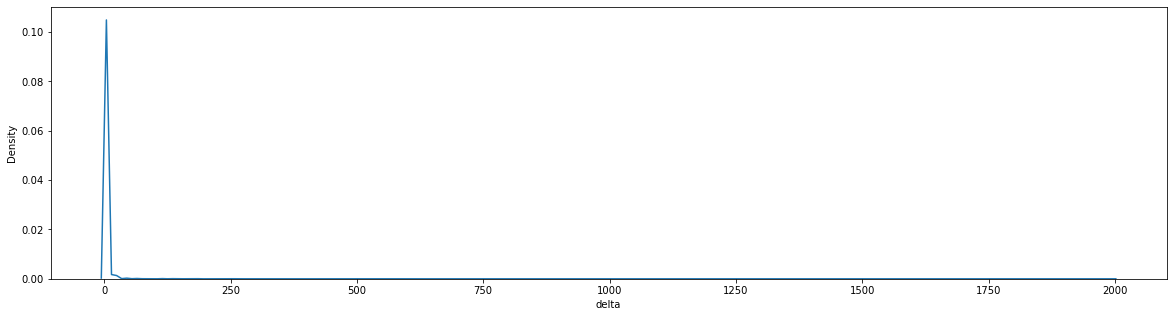

In [422]:
%matplotlib inline
plt.figure(figsize=(20,5))
sns.kdeplot(data=X_test['delta'])